In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from truncation import get_truncation

In [2]:
# %matplotlib widget
%matplotlib inline

In [3]:
FORCES = ["LO", "NLO", "N2LO", "N3LO", "N4LO", "N4LO+"]
CUTOFF = [400, 450, 500, 550]

plt.style.use(['science', 'retro'])

mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'DejaVu Sans'
mpl.rcParams['mathtext.it'] = 'DejaVu Sans:italic'
mpl.rcParams['mathtext.bf'] = 'DejaVu Sans:bold'

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "DejaVu Sans"

plt.rc('text', usetex=True)
plt.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['lines.linewidth'] = 2

line_styles = {"LO": {"marker": "d", "markevery": 10, "markersize": 3, "color": "tab:cyan"},
               "NLO": {"marker": ".", "markevery": 10, "color": "orange"},
               "N2LO": {"ls":  (0, (5, 3)), "color": "green"},
               "N3LO": {"ls": "dotted", "color": "blue"},
               "N4LO": {"ls": (0, (5, 2, 0.8, 2, 0.8, 2)), "color": "red"},
               "N4LO+": {"color": "black"},
               "AV18": {"ls": (0, (5, 2, 1.3, 2,)), "color": "blueviolet"},
               "SIEGERT": {"color": "blue"},
               "1NC": {"color": "deeppink", "ls": "dashed"}
               }
ls_cutoff = {400: line_styles["N4LO"],
             450: line_styles["N4LO+"],
             500: line_styles["N2LO"],
             550: line_styles["N3LO"],
             }

trunc_colors = {
    "NLO": "bisque",
    "N2LO": "limegreen",
    "N3LO": "dodgerblue",
    "N4LO": "red",
    "N4LO+": "black",
}

marker_common = {"markersize": 6, "elinewidth": 0.9, "capsize": 2.5}


In [4]:
def relative_diff(*args):
    return (max(args) - min(args))/np.mean(args)

In [5]:
src_incl = "He_photodis/incl_10pp40/"
src = "Triton/Triton_2NF/"
forces = ["LO", "NLO", "N2LO", "N3LO", "N4LO", "N4LO+"]

# pnn

## Exclusive

In [6]:
files = [file for file in os.listdir(src) if "incl" not in file and file.startswith("pnn")] 

In [18]:
# fname = files40[0]
def read_data(fname):
    df = pd.read_csv(src + fname, skiprows=1, skipinitialspace=True, sep=" ")
    df["Energy"] = float(fname.split("-")[2])
    df["FORCE"] = fname.split("-")[3].split("_")[-1]
    df["CUTOFF"] = int(fname.split("-")[1][-3:])
    df["CONFIG"] = fname.split("-")[-1]
    return df

In [19]:
df1 = pd.concat([read_data(fname) for fname in files], ignore_index=True)
df1.sort_values("SLANGE", inplace=True)
df1.to_csv("Triton_pnn_excl.csv", index=False)

In [20]:
df1 = pd.read_csv("Triton_pnn_excl.csv")

In [21]:
df1.head()

,I,SLANGE,CROSS,E1,E2,E3,Energy,FORCE,CUTOFF,CONFIG
0,1,0.5,1.813000e-07,12.436,0.031,9.072,30.0,N4LO,450,15_0_15_180
1,1,0.5,1.924000e-07,12.436,0.031,9.072,30.0,N4LO+,550,15_0_15_180
2,1,0.5,1.803000e-07,12.436,0.031,9.072,30.0,N2LO,450,15_0_15_180
3,1,0.5,1.637000e-07,12.436,0.031,9.072,30.0,NLO,450,15_0_15_180
4,1,0.5,6.045000e-07,10.629,0.029,10.882,30.0,LO,450,75_75_75_105


In [34]:
df1.CONFIG.unique()

array(['15_0_15_180', '75_75_75_105', '15_105_15_75', '45_75_45_105',
       '165_15_15_165'], dtype=object)

### Truncation

#### 75_75_75_105

In [63]:
# fig, axes = plt.subplots(1,2, figsize=(7,2.8))
en=30
config = "75_75_75_105"
# en=100

df_tmp = df1[(df1.CUTOFF == 450) &
             (df1.Energy == en) &
             (df1["CONFIG"] == config)]
df_tmp.sort_values("SLANGE", inplace=True)
df_piv = df_tmp.pivot(index="SLANGE", columns="FORCE")[
    "CROSS"].reindex(FORCES, axis=1)
df_trunc = get_truncation(df_piv, en, Lambda=650)

/home/vitalii/anaconda3/envs/experimental/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


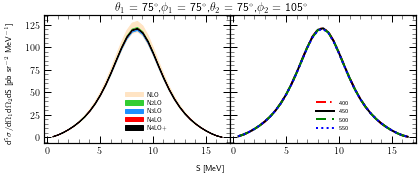

In [64]:
fig = plt.figure(figsize=(6, 2.8))
gs = fig.add_gridspec(ncols=2, wspace=0)
axes = gs.subplots(sharey=True)
fig.suptitle("$\\theta_1$ = {}$^\circ$,"
             "$\\phi_1$ = {}$^\circ$,"
             "$\\theta_2$ = {}$^\circ$,"
             "$\\phi_2$ = {}$^\circ$".format(*config.split("_")), y=0.9)
fig.supylabel("$\\text{d}^5\sigma/\\text{d}\Omega _1\\text{d}\Omega_2$dS [pb sr$^{-2}$ MeV$^{-1}$]", size=8)
fig.supxlabel("S [MeV]", size=8, y=0.06)

for force in FORCES[1:]:
    df_tmp =  df1[(df1["CUTOFF"]==450) & (df1["Energy"] == en)
                  & (df1["FORCE"] == force) &
                  (df1["CONFIG"] == config)]
    # axes[0].plot(df_tmp["SLANGE"], df_tmp["CROSS"], **line_styles[force], label=force)
    axes[0].fill_between(df_tmp.SLANGE, 10**6*(df_tmp["CROSS"].values+df_trunc[force].values),
                            10**6*(df_tmp["CROSS"].values-df_trunc[force].values), label=force,
                            color=trunc_colors[force])
for cut in CUTOFF:
    df_tmp =  df1[(df1["CUTOFF"]==cut) & (df1["Energy"] == en)
                  & (df1["FORCE"] == "N4LO+") &
                  (df1["CONFIG"] == config)]
    axes[1].plot(df_tmp["SLANGE"], 10**6*df_tmp["CROSS"], **ls_cutoff[cut], label=cut)
for j, ax in enumerate(axes):
    ax.tick_params(which='minor', direction='in', length=4,
                   width=0.5, top=True, right=True)
    ax.tick_params(which='major', direction='in',
                   length=7, width=1, top=True, right=True, zorder=1)
    ax.set_zorder(-1)
    ax.legend(fontsize=6, handlelength=3, loc="lower center", bbox_to_anchor=(0.05, 0.05, 1.0, 1.0))  # 30 MeV
    # if en == 30:
    # else:
    #     ax.legend(fontsize=6, handlelength=3, loc="upper center", bbox_to_anchor=(0.05, 0, 1, 0.9))  # 100 MeV
plt.tight_layout()

plt.savefig(f"Figures_Triton/CROSS_excl_trunc_{en}mev_{config}_2NF.pdf", dpi=600, facecolor="white")


#### 15_0_15_180

In [65]:
# fig, axes = plt.subplots(1,2, figsize=(7,2.8))
en=30
config = "15_0_15_180"
# en=100

df_tmp = df1[(df1.CUTOFF == 450) &
             (df1.Energy == en) &
             (df1["CONFIG"] == config)]
df_tmp.sort_values("SLANGE", inplace=True)
df_piv = df_tmp.pivot(index="SLANGE", columns="FORCE")[
    "CROSS"].reindex(FORCES, axis=1)
df_trunc = get_truncation(df_piv, en, Lambda=650)

/home/vitalii/anaconda3/envs/experimental/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


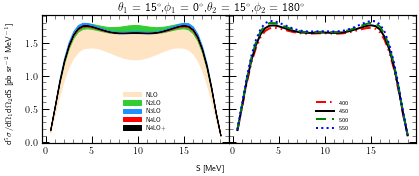

In [66]:
fig = plt.figure(figsize=(6, 2.8))
gs = fig.add_gridspec(ncols=2, wspace=0)
axes = gs.subplots(sharey=True)
fig.suptitle("$\\theta_1$ = {}$^\circ$,"
             "$\\phi_1$ = {}$^\circ$,"
             "$\\theta_2$ = {}$^\circ$,"
             "$\\phi_2$ = {}$^\circ$".format(*config.split("_")), y=0.9)
fig.supylabel("$\\text{d}^5\sigma/\\text{d}\Omega _1\\text{d}\Omega_2$dS [pb sr$^{-2}$ MeV$^{-1}$]", size=8)
fig.supxlabel("S [MeV]", size=8, y=0.06)

for force in FORCES[1:]:
    df_tmp =  df1[(df1["CUTOFF"]==450) & (df1["Energy"] == en)
                  & (df1["FORCE"] == force) &
                  (df1["CONFIG"] == config)]
    # axes[0].plot(df_tmp["SLANGE"], df_tmp["CROSS"], **line_styles[force], label=force)
    axes[0].fill_between(df_tmp.SLANGE, 10**6*(df_tmp["CROSS"].values+df_trunc[force].values),
                            10**6*(df_tmp["CROSS"].values-df_trunc[force].values), label=force,
                            color=trunc_colors[force])
for cut in CUTOFF:
    df_tmp =  df1[(df1["CUTOFF"]==cut) & (df1["Energy"] == en)
                  & (df1["FORCE"] == "N4LO+") &
                  (df1["CONFIG"] == config)]
    axes[1].plot(df_tmp["SLANGE"], 10**6*df_tmp["CROSS"], **ls_cutoff[cut], label=cut)
for j, ax in enumerate(axes):
    ax.tick_params(which='minor', direction='in', length=4,
                   width=0.5, top=True, right=True)
    ax.tick_params(which='major', direction='in',
                   length=7, width=1, top=True, right=True, zorder=1)
    ax.set_zorder(-1)
    ax.legend(fontsize=6, handlelength=3, loc="lower center", bbox_to_anchor=(0.05, 0.05, 1.0, 1.0))  # 30 MeV
    # if en == 30:
    # else:
    #     ax.legend(fontsize=6, handlelength=3, loc="upper center", bbox_to_anchor=(0.05, 0, 1, 0.9))  # 100 MeV
plt.tight_layout()

plt.savefig(f"Figures_Triton/CROSS_excl_trunc_{en}mev_{config}_2NF.pdf", dpi=600, facecolor="white")


#### 15_105_15_75

In [67]:
# fig, axes = plt.subplots(1,2, figsize=(7,2.8))
en=30
config = "15_105_15_75"
# en=100

df_tmp = df1[(df1.CUTOFF == 450) &
             (df1.Energy == en) &
             (df1["CONFIG"] == config)]
df_tmp.sort_values("SLANGE", inplace=True)
df_piv = df_tmp.pivot(index="SLANGE", columns="FORCE")[
    "CROSS"].reindex(FORCES, axis=1)
df_trunc = get_truncation(df_piv, en, Lambda=650)

/home/vitalii/anaconda3/envs/experimental/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


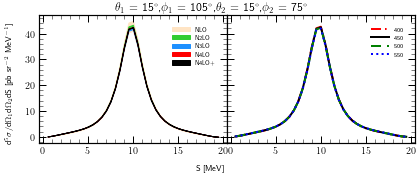

In [68]:
fig = plt.figure(figsize=(6, 2.8))
gs = fig.add_gridspec(ncols=2, wspace=0)
axes = gs.subplots(sharey=True)
fig.suptitle("$\\theta_1$ = {}$^\circ$,"
             "$\\phi_1$ = {}$^\circ$,"
             "$\\theta_2$ = {}$^\circ$,"
             "$\\phi_2$ = {}$^\circ$".format(*config.split("_")), y=0.9)
fig.supylabel("$\\text{d}^5\sigma/\\text{d}\Omega _1\\text{d}\Omega_2$dS [pb sr$^{-2}$ MeV$^{-1}$]", size=8)
fig.supxlabel("S [MeV]", size=8, y=0.06)

for force in FORCES[1:]:
    df_tmp =  df1[(df1["CUTOFF"]==450) & (df1["Energy"] == en)
                  & (df1["FORCE"] == force) &
                  (df1["CONFIG"] == config)]
    # axes[0].plot(df_tmp["SLANGE"], df_tmp["CROSS"], **line_styles[force], label=force)
    axes[0].fill_between(df_tmp.SLANGE, 10**6*(df_tmp["CROSS"].values+df_trunc[force].values),
                            10**6*(df_tmp["CROSS"].values-df_trunc[force].values), label=force,
                            color=trunc_colors[force])
for cut in CUTOFF:
    df_tmp =  df1[(df1["CUTOFF"]==cut) & (df1["Energy"] == en)
                  & (df1["FORCE"] == "N4LO+") &
                  (df1["CONFIG"] == config)]
    axes[1].plot(df_tmp["SLANGE"], 10**6*df_tmp["CROSS"], **ls_cutoff[cut], label=cut)
for j, ax in enumerate(axes):
    ax.tick_params(which='minor', direction='in', length=4,
                   width=0.5, top=True, right=True)
    ax.tick_params(which='major', direction='in',
                   length=7, width=1, top=True, right=True, zorder=1)
    ax.set_zorder(-1)
    ax.legend(fontsize=6, handlelength=3, loc="upper right", bbox_to_anchor=(0.05, 0.05, 0.92, 0.9))  # 30 MeV
    # if en == 30:
    # else:
    #     ax.legend(fontsize=6, handlelength=3, loc="upper center", bbox_to_anchor=(0.05, 0, 1, 0.9))  # 100 MeV
plt.tight_layout()

plt.savefig(f"Figures_Triton/CROSS_excl_trunc_{en}mev_{config}_2NF.pdf", dpi=600, facecolor="white")


#### 45_75_45_105

In [69]:
# fig, axes = plt.subplots(1,2, figsize=(7,2.8))
en=30
config = "45_75_45_105"
# en=100

df_tmp = df1[(df1.CUTOFF == 450) &
             (df1.Energy == en) &
             (df1["CONFIG"] == config)]
df_tmp.sort_values("SLANGE", inplace=True)
df_piv = df_tmp.pivot(index="SLANGE", columns="FORCE")[
    "CROSS"].reindex(FORCES, axis=1)
df_trunc = get_truncation(df_piv, en, Lambda=650)

/home/vitalii/anaconda3/envs/experimental/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


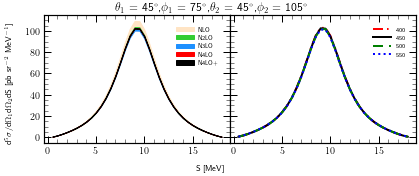

In [70]:
fig = plt.figure(figsize=(6, 2.8))
gs = fig.add_gridspec(ncols=2, wspace=0)
axes = gs.subplots(sharey=True)
fig.suptitle("$\\theta_1$ = {}$^\circ$,"
             "$\\phi_1$ = {}$^\circ$,"
             "$\\theta_2$ = {}$^\circ$,"
             "$\\phi_2$ = {}$^\circ$".format(*config.split("_")), y=0.9)
fig.supylabel("$\\text{d}^5\sigma/\\text{d}\Omega _1\\text{d}\Omega_2$dS [pb sr$^{-2}$ MeV$^{-1}$]", size=8)
fig.supxlabel("S [MeV]", size=8, y=0.06)

for force in FORCES[1:]:
    df_tmp =  df1[(df1["CUTOFF"]==450) & (df1["Energy"] == en)
                  & (df1["FORCE"] == force) &
                  (df1["CONFIG"] == config)]
    # axes[0].plot(df_tmp["SLANGE"], df_tmp["CROSS"], **line_styles[force], label=force)
    axes[0].fill_between(df_tmp.SLANGE, 10**6*(df_tmp["CROSS"].values+df_trunc[force].values),
                            10**6*(df_tmp["CROSS"].values-df_trunc[force].values), label=force,
                            color=trunc_colors[force])
for cut in CUTOFF:
    df_tmp =  df1[(df1["CUTOFF"]==cut) & (df1["Energy"] == en)
                  & (df1["FORCE"] == "N4LO+") &
                  (df1["CONFIG"] == config)]
    axes[1].plot(df_tmp["SLANGE"], 10**6*df_tmp["CROSS"], **ls_cutoff[cut], label=cut)
for j, ax in enumerate(axes):
    ax.tick_params(which='minor', direction='in', length=4,
                   width=0.5, top=True, right=True)
    ax.tick_params(which='major', direction='in',
                   length=7, width=1, top=True, right=True, zorder=1)
    ax.set_zorder(-1)
    ax.legend(fontsize=6, handlelength=3, loc="upper right", bbox_to_anchor=(0.05, 0.05, 0.92, 0.9))  # 30 MeV
    # if en == 30:
    # else:
    #     ax.legend(fontsize=6, handlelength=3, loc="upper center", bbox_to_anchor=(0.05, 0, 1, 0.9))  # 100 MeV
plt.tight_layout()

plt.savefig(f"Figures_Triton/CROSS_excl_trunc_{en}mev_{config}_2NF.pdf", dpi=600, facecolor="white")


#### 165_15_15_165

In [71]:
# fig, axes = plt.subplots(1,2, figsize=(7,2.8))
en=30
config = "165_15_15_165"
# en=100

df_tmp = df1[(df1.CUTOFF == 450) &
             (df1.Energy == en) &
             (df1["CONFIG"] == config)]
df_tmp.sort_values("SLANGE", inplace=True)
df_piv = df_tmp.pivot(index="SLANGE", columns="FORCE")[
    "CROSS"].reindex(FORCES, axis=1)
df_trunc = get_truncation(df_piv, en, Lambda=650)

/home/vitalii/anaconda3/envs/experimental/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


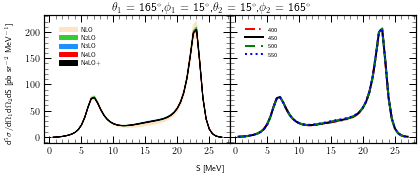

In [72]:
fig = plt.figure(figsize=(6, 2.8))
gs = fig.add_gridspec(ncols=2, wspace=0)
axes = gs.subplots(sharey=True)
fig.suptitle("$\\theta_1$ = {}$^\circ$,"
             "$\\phi_1$ = {}$^\circ$,"
             "$\\theta_2$ = {}$^\circ$,"
             "$\\phi_2$ = {}$^\circ$".format(*config.split("_")), y=0.9)
fig.supylabel("$\\text{d}^5\sigma/\\text{d}\Omega _1\\text{d}\Omega_2$dS [pb sr$^{-2}$ MeV$^{-1}$]", size=8)
fig.supxlabel("S [MeV]", size=8, y=0.06)

for force in FORCES[1:]:
    df_tmp =  df1[(df1["CUTOFF"]==450) & (df1["Energy"] == en)
                  & (df1["FORCE"] == force) &
                  (df1["CONFIG"] == config)]
    # axes[0].plot(df_tmp["SLANGE"], df_tmp["CROSS"], **line_styles[force], label=force)
    axes[0].fill_between(df_tmp.SLANGE, 10**6*(df_tmp["CROSS"].values+df_trunc[force].values),
                            10**6*(df_tmp["CROSS"].values-df_trunc[force].values), label=force,
                            color=trunc_colors[force])
for cut in CUTOFF:
    df_tmp =  df1[(df1["CUTOFF"]==cut) & (df1["Energy"] == en)
                  & (df1["FORCE"] == "N4LO+") &
                  (df1["CONFIG"] == config)]
    axes[1].plot(df_tmp["SLANGE"], 10**6*df_tmp["CROSS"], **ls_cutoff[cut], label=cut)
for j, ax in enumerate(axes):
    ax.tick_params(which='minor', direction='in', length=4,
                   width=0.5, top=True, right=True)
    ax.tick_params(which='major', direction='in',
                   length=7, width=1, top=True, right=True, zorder=1)
    ax.set_zorder(-1)
    ax.legend(fontsize=6, handlelength=3, loc="upper left", bbox_to_anchor=(0.05, 0.05, 0.92, 0.9))  # 30 MeV
    # if en == 30:
    # else:
    #     ax.legend(fontsize=6, handlelength=3, loc="upper center", bbox_to_anchor=(0.05, 0, 1, 0.9))  # 100 MeV
plt.tight_layout()

plt.savefig(f"Figures_Triton/CROSS_excl_trunc_{en}mev_{config}_2NF.pdf", dpi=600, facecolor="white")


In [28]:
df_tmp = df1[(df1.CUTOFF == 450) &
(df1.FORCE.isin(["N4LO", "N4LO+"])) &
                (df1.Energy == 30)]

In [30]:
reldif = df_tmp.pivot(index="SLANGE", columns="FORCE")["CROSS"].apply(lambda x: relative_diff(*x), axis=1)*100

In [58]:
order="N4LO+"
df_tmp = df1[(df1.FORCE == order) &
                    (df1.CUTOFF == 450) &
                    (df1.Energy == 30)][["SLANGE", "CROSS"]]
df_tmp["CROSS+"] = df_tmp["CROSS"] + df_trunc[order].values
df_tmp["CROSS-"] = df_tmp["CROSS"] - df_trunc[order].values

In [80]:
(df_tmp[["CROSS-", "CROSS+"]].apply(lambda x: relative_diff(*x), axis=1)*100)\
            .sort_values(ascending=False).loc[1251]

0.1264591278621783

In [79]:
df_tmp.loc[1251]

SLANGE    10.003000
CROSS      0.000001
CROSS+     0.000001
CROSS-     0.000001
Name: 1251, dtype: float64

In [82]:
df_tmp = df1[(df1.FORCE == "N4LO+") &
                    (df1.Energy == 30)]
reldif2 = df_tmp.pivot(index="SLANGE", columns="CUTOFF")["CROSS"].apply(lambda x: relative_diff(*x), axis=1)*100

/tmp/ipykernel_400781/2869571843.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.sort_values("SLANGE", inplace=True)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  maxdiff.append(df_diff[FORCES[force_num-1]]*EPSILON)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  maxdiff.append(df_diff[FORCES[force_num-1]]*EPSILON)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas

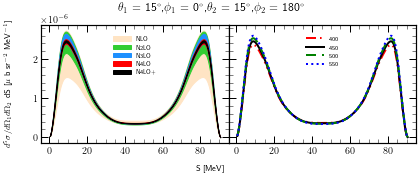

In [96]:
# fig, axes = plt.subplots(1,2, figsize=(7,2.8))
en=100

df_tmp = df1[(df1.CUTOFF == 450) &
             (df1.Energy == en)]
df_tmp.sort_values("SLANGE", inplace=True)
df_piv = df_tmp.pivot(index="SLANGE", columns="FORCE")[
    "CROSS"].reindex(FORCES, axis=1)
df_trunc = get_truncation(df_piv, en, Lambda=650)

fig = plt.figure(figsize=(6, 2.8))
gs = fig.add_gridspec(ncols=2, wspace=0)
axes = gs.subplots(sharey=True)
fig.suptitle("$\\theta_1$ = {}$^\circ$,"
             "$\\phi_1$ = {}$^\circ$,"
             "$\\theta_2$ = {}$^\circ$,"
             "$\\phi_2$ = {}$^\circ$".format(15, 0, 15, 180), y=0.9)
fig.supylabel("$d^5\sigma/d\Omega _1 d\Omega _2$ dS [$\mu$ b sr$^{-2}$ MeV$^{-1}$]", size=8)
fig.supxlabel("S [MeV]", size=8, y=0.06)

for force in FORCES[1:]:
    df_tmp =  df1[(df1["CUTOFF"]==450) & (df1["Energy"] == en)
                   & (df1["FORCE"] == force) ]
    # axes[0].plot(df_tmp["SLANGE"], df_tmp["CROSS"], **line_styles[force], label=force)
    axes[0].fill_between(df_tmp.SLANGE, df_tmp["CROSS"].values+df_trunc[force].values,
                            df_tmp["CROSS"].values-df_trunc[force].values, label=force,
                            color=trunc_colors[force])
for cut in CUTOFF:
    df_tmp =  df1[(df1["CUTOFF"]==cut) & (df1["Energy"] == en)
                   & (df1["FORCE"] == "N4LO+") ]
    axes[1].plot(df_tmp["SLANGE"], df_tmp["CROSS"], **ls_cutoff[cut], label=cut)
for j, ax in enumerate(axes):
    ax.tick_params(which='minor', direction='in', length=4,
                   width=0.5, top=True, right=True)
    ax.tick_params(which='major', direction='in',
                   length=7, width=1, top=True, right=True, zorder=1)
    # ax.set_xticks(np.arange(0, 180+j-1, 30))
    # ax.set_xlim([0, 180])
    # ax.grid(alpha=0.2)
    ax.set_zorder(-1)
    ax.legend(fontsize=6, handlelength=3, loc="upper center", bbox_to_anchor=(0., 0.45, 1., 0.5))
plt.tight_layout()

plt.savefig(f"Figures_Triton/CROSS_excl_trunc_{en}mev.pdf", dpi=600, facecolor="white")


In [114]:
order="N4LO+"
en = 100
df_tmp = df1[(df1.FORCE == order) &
                    (df1.CUTOFF == 450) &
                    (df1.Energy == en)][["SLANGE", "CROSS"]]
df_tmp["CROSS+"] = df_tmp["CROSS"] + df_trunc[order].values
df_tmp["CROSS-"] = df_tmp["CROSS"] - df_trunc[order].values

In [115]:
(df_tmp[df_tmp["SLANGE"] == 10.001][["CROSS-", "CROSS+"]].apply(lambda x: relative_diff(*x), axis=1)*100).sort_values(ascending=False).iloc[:10]

1242    2.147389
dtype: float64

In [116]:
df_tmp[df_tmp["SLANGE"] == 10.001]

,SLANGE,CROSS,CROSS+,CROSS-
1242,10.001,0.000002,0.000002,0.000002


In [120]:
df_tmp = df1[(df1.FORCE == "N4LO+") &
                    (df1.Energy == en)]
reldif2 = df_tmp.pivot(index="SLANGE", columns="CUTOFF")["CROSS"].apply(lambda x: relative_diff(*x), axis=1)*100

### Inclusive

In [71]:
files_inc = [file for file in os.listdir(src)
       zz      if "incl" in file and file.startswith("pnn")] 

In [72]:
files_inc2 = os.listdir(src_incl) 

In [73]:
def read_data_incl(fname, src=src):
    df = pd.read_csv(src + fname, skiprows=8, skipinitialspace=True, sep=" ")
    df["FORCE"] = fname.split("-")[3].split("_")[-1]
    try:
        df["CUTOFF"] = int(fname.split("-")[1][-3:])
        df["Energy"] = float(fname.split("-")[2])
    except:
        df["CUTOFF"] = int(fname.split("-")[2][-3:])
        df["Energy"] = float(fname.split("-")[1])
    if fname.split("-")[-2] == "incl":
        df["angle"] = int(fname.split("-")[-1][:-3])
    else:
        df["angle"] = int(fname.split("-")[-4][:-3])
    return df

In [34]:
# df2 = pd.concat([read_data_incl(fname, src=src_incl) for fname in files_inc2], ignore_index=True)

In [35]:
# df2.sort_values("E1", inplace=True)

In [36]:
# df2.to_csv("HE_pnn_incl_new_angles_10pp40.csv", index=False)

In [74]:
df2 = pd.read_csv("HE_pnn_incl_new_angles_10pp40.csv")

In [75]:
import matplotlib.ticker

In [76]:
def create_subtitle(fig: plt.Figure, grid: mpl.gridspec.SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold', y=0.88)
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

/tmp/ipykernel_1118639/3808634026.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.sort_values("E1", inplace=True)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  maxdiff.append(df_diff[FORCES[force_num-1]]*EPSILON)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  maxdiff.append(df_diff[FORCES[force_num-1]]*EPSILON)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in

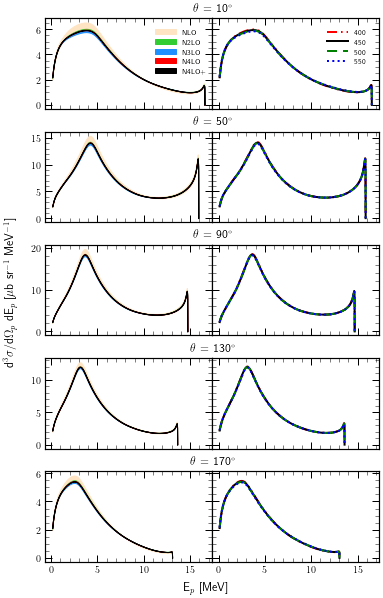

In [81]:
# for en in [30]:
en = 30
df_tmp = df2[(df2.CUTOFF == 450) & (df2["Energy"] == en)]
df_tmp.sort_values("E1", inplace=True)
df_piv = df_tmp.pivot(index=["E1", "angle"], columns="FORCE")[
    "CROSS"].reindex(FORCES, axis=1)
df_piv = df_piv.reset_index(level=1)


fig = plt.figure(figsize=(6, 10))
gs = fig.add_gridspec(ncols=2, nrows=5, wspace=0, hspace=0.25)
axes = gs.subplots(sharey="row", sharex="col")
obs = "CROSS"
fig.supylabel("$\\text{d}^3\sigma/\\text{d}\Omega _p$ \\text{d}E$_p$ [$\mu$b sr$^{-1}$ MeV$^{-1}$]", size=12, x=0.03)
fig.supxlabel("E$_p$ [MeV]", size=12, y=0.08)
for i, angle in enumerate(np.sort(df2["angle"].unique())):
    # axes[i, 0].ticklabel_format(axis="y", style="sci", scilimits=(-5, -5))
    create_subtitle(fig, gs[i, 0:2], f"$\\theta$ = {angle}$^\circ$")
    
    df_trunc = get_truncation(df_piv[df_piv.angle == angle].drop(
        "angle", axis=1), en, Lambda=650)
    for force in FORCES[1:]:
        df_tmp =  df2[(df2["CUTOFF"]==450) & (df2["Energy"] == en)
                        & (df2["FORCE"] == force) & (df2["angle"] == angle)]
        axes[i, 0].fill_between(df_tmp["E1"], 10**4*(df_tmp["CROSS"].values+df_trunc[force].values),
                             10**4*(df_tmp["CROSS"].values-df_trunc[force].values), label=force,
                             color=trunc_colors[force])
        # axes[i, 0].plot(df_tmp["E1"], df_tmp[obs], **line_styles[force], label=force)
    for cut in CUTOFF:
        df_tmp =  df2[(df2["CUTOFF"]==cut) & (df2["Energy"] == en)
                        & (df2["FORCE"] == "N4LO+") & (df2["angle"] == angle)]
        axes[i, 1].plot(df_tmp["E1"], 10**4*df_tmp[obs], **ls_cutoff[cut], label=cut)
    for j, ax in enumerate(axes[i]):
        ax.tick_params(which='minor', direction='in', length=4,
                    width=0.5, top=True, right=True)
        ax.tick_params(which='major', direction='in',
                    length=7, width=1, top=True, right=True, zorder=1)
        # ax.grid(alpha=0.2)
        ax.set_zorder(-1)
axes[0,0].legend(fontsize=7, handlelength=3, bbox_to_anchor=(0,0,1,0.95))
axes[0,1].legend(fontsize=7, handlelength=3, bbox_to_anchor=(0,0,0.95,0.95))
plt.tight_layout()
plt.savefig(f"Figures_Triton/{obs}_incl_trunc_{en}mev_all.pdf", dpi=300, facecolor="white")
    # plt.close()
plt.show()


In [82]:
order = "N4LO+"
en = 100
angle = 10
df_tmp = df2[(df2.CUTOFF == 450) & (df2["Energy"] == en)]
df_tmp.sort_values("E1", inplace=True)
df_piv = df_tmp.pivot(index=["E1", "angle"], columns="FORCE")[
    "CROSS"].reindex(FORCES, axis=1)
df_piv = df_piv.reset_index(level=1)
for angle in np.arange(10, 180,40):
    df_trunc = get_truncation(df_piv[df_piv.angle == angle].drop(
        "angle", axis=1), en, Lambda=650)
    df_tmp = df2[(df2.FORCE == order) &
                (df2.CUTOFF == 450) &
                (df2.Energy == en) &
                (df2.angle == angle)][["E1", "CROSS"]]
    df_tmp["CROSS+"] = df_tmp["CROSS"] + df_trunc[order].values
    df_tmp["CROSS-"] = df_tmp["CROSS"] - df_trunc[order].values

    print("angle:", angle)
    print("%.2f percent" % (df_tmp.iloc[(df_tmp['E1']-1.463).abs().argsort()[:1]][["CROSS-", "CROSS+"]]
        .apply(lambda x: relative_diff(*x), axis=1)*100).values[0])
    # print("%.2f percent" % (df_tmp.iloc[(df_tmp['E1']-3.882).abs().argsort()[:1]][["CROSS-", "CROSS+"]]
    #     .apply(lambda x: relative_diff(*x), axis=1)*100).values[0])


angle: 10
1.68 percent
angle: 50
1.67 percent
angle: 90
1.56 percent
angle: 130
1.43 percent
angle: 170
1.42 percent


/tmp/ipykernel_1118639/1230759323.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.sort_values("E1", inplace=True)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  maxdiff.append(df_diff[FORCES[force_num-1]]*EPSILON)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  maxdiff.append(df_diff[FORCES[force_num-1]]*EPSILON)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in

In [160]:
order = "N4LO+"
en = 100
for angle in np.arange(10, 180, 40):
    df_tmp = df2[(df2.FORCE == order) &
                (df2.Energy == en) &
                (df2.angle == angle)]
    reldif2 = (df_tmp.pivot(index="E1", columns="CUTOFF")[
        "CROSS"].apply(lambda x: relative_diff(*x), axis=1)*100).reset_index()
    print("angle:", angle)
    # print("%.2f percent" % (reldif2.iloc[(df_tmp['E1']-1.463).abs().argsort()[:1]])
    # print("%.2f percent" % (reldif2.iloc[(df_tmp['E1']-3.882).abs().argsort()[:1]]))
    print("%.2f percent" %
        #   reldif2.iloc[(reldif2['E1']-3.882).abs().argsort()[:1]][0].values[0])
      reldif2.iloc[(reldif2['E1']-1.463).abs().argsort()[:1]][0].values[0])


angle: 10
7.62 percent
angle: 50
9.39 percent
angle: 90
7.99 percent
angle: 130
6.57 percent
angle: 170
5.90 percent


/tmp/ipykernel_1118639/3757287857.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.sort_values("E1", inplace=True)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  maxdiff.append(df_diff[FORCES[force_num-1]]*EPSILON)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  maxdiff.append(df_diff[FORCES[force_num-1]]*EPSILON)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in

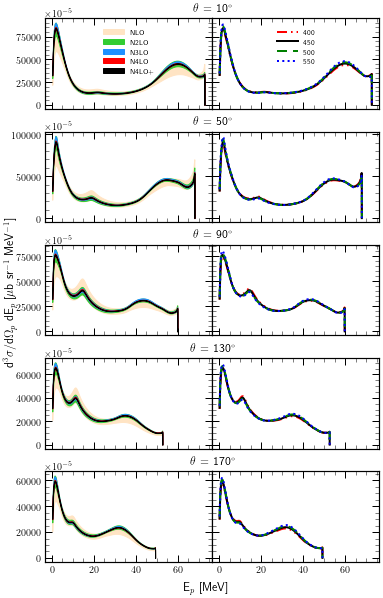

In [83]:
# for en in [30]:
en = 100
df_tmp = df2[(df2.CUTOFF == 450) & (df2["Energy"] == en)]
df_tmp.sort_values("E1", inplace=True)
df_piv = df_tmp.pivot(index=["E1", "angle"], columns="FORCE")[
    "CROSS"].reindex(FORCES, axis=1)
df_piv = df_piv.reset_index(level=1)


fig = plt.figure(figsize=(6, 10))
gs = fig.add_gridspec(ncols=2, nrows=5, wspace=0, hspace=0.25)
axes = gs.subplots(sharey="row", sharex="col")
obs = "CROSS"
fig.supylabel("$\\text{d}^3\sigma/\\text{d}\Omega _p$ dE$_p$ [$\mu$b sr$^{-1}$ MeV$^{-1}$]", size=12, x=0.03)
fig.supxlabel("E$_p$ [MeV]", size=12, y=0.08)
for i, angle in enumerate(np.sort(df2["angle"].unique())):
    axes[i, 0].ticklabel_format(axis="y", style="sci", scilimits=(-5, -5))
    create_subtitle(fig, gs[i, 0:2], f"$\\theta$ = {angle}$^\circ$")
    
    df_trunc = get_truncation(df_piv[df_piv.angle == angle].drop(
        "angle", axis=1), en, Lambda=650)
    for force in FORCES[1:]:
        df_tmp =  df2[(df2["CUTOFF"]==450) & (df2["Energy"] == en)
                        & (df2["FORCE"] == force) & (df2["angle"] == angle)]
        axes[i, 0].fill_between(df_tmp["E1"], 10**4*(df_tmp["CROSS"].values+df_trunc[force].values),
                             10**4*(df_tmp["CROSS"].values-df_trunc[force].values), label=force,
                             color=trunc_colors[force])
        # axes[i, 0].plot(df_tmp["E1"], df_tmp[obs], **line_styles[force], label=force)
    for cut in CUTOFF:
        df_tmp =  df2[(df2["CUTOFF"]==cut) & (df2["Energy"] == en)
                        & (df2["FORCE"] == "N4LO+") & (df2["angle"] == angle)]
        axes[i, 1].plot(df_tmp["E1"], 10**4*df_tmp[obs], **ls_cutoff[cut], label=cut)
    for j, ax in enumerate(axes[i]):
        ax.tick_params(which='minor', direction='in', length=4,
                    width=0.5, top=True, right=True)
        ax.tick_params(which='major', direction='in',
                    length=7, width=1, top=True, right=True, zorder=1)
        # ax.grid(alpha=0.2)
        ax.set_zorder(-1)
axes[0,0].legend(fontsize=7, handlelength=3, loc="upper center", bbox_to_anchor=(0,0,1,0.95))
axes[0,1].legend(fontsize=7, handlelength=3, bbox_to_anchor=(0,0,1,0.95))
fig.tight_layout()
plt.savefig(f"Figures_Triton/{obs}_incl_trunc_{en}mev_all.pdf", dpi=300, facecolor="white")
    # plt.close()
plt.show()
